# Conv1D와 LSTM을 이용한 IMDB 분류
- 모든 단어가 아닌 빈도수 5000 까지
- 모든 문장이 아니라 500 단어까지

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
from tensorflow.keras.datasets import imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [5]:
# 모델의 입력으로 사용하는 모든 리뷰의 길이를 동일하게 500으로 맞춤
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

- 테스트 데이터 25,000개 중 10,000개는 검증셋, 15,000개는 실제 테스트셋으로 사용

In [6]:
from sklearn.model_selection import train_test_split
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, stratify=y_test, test_size=0.6, random_state=seed
)

In [7]:
X_val.shape, X_test.shape

((10000, 500), (15000, 500))

### 모델 정의/설정/학습/평가

In [8]:
# LSTM 모델
model = Sequential()
model.add(Embedding(5000, 120))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(60))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 120)         600000    
_________________________________________________________________
dropout (Dropout)            (None, None, 120)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 60)                30000     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 668,525
Trainable params: 668,525
Non-trainable params: 0
__________________________________________________

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [10]:
# Callback 함수 정의 - Best model, Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('model/imdb_conv1d_lstm_best_model.h5', monitor='val_loss', 
                     mode='max', verbose=1, save_best_only=True)

In [11]:
# 모델의 실행
history = model.fit(X_train, y_train, batch_size=100, epochs=50, 
                    validation_data=(X_val, y_val), verbose=2, 
                    callbacks=[mc, es])

Epoch 1/50
250/250 - 11s - loss: 0.4009 - accuracy: 0.8015 - val_loss: 0.2999 - val_accuracy: 0.8743

Epoch 00001: val_loss improved from -inf to 0.29988, saving model to model/imdb_conv1d_lstm_best_model.h5
Epoch 2/50
250/250 - 8s - loss: 0.2308 - accuracy: 0.9091 - val_loss: 0.2653 - val_accuracy: 0.8927

Epoch 00002: val_loss did not improve from 0.29988
Epoch 3/50
250/250 - 8s - loss: 0.1900 - accuracy: 0.9276 - val_loss: 0.2812 - val_accuracy: 0.8882

Epoch 00003: val_loss did not improve from 0.29988
Epoch 4/50
250/250 - 8s - loss: 0.1590 - accuracy: 0.9421 - val_loss: 0.3084 - val_accuracy: 0.8810

Epoch 00004: val_loss improved from 0.29988 to 0.30844, saving model to model/imdb_conv1d_lstm_best_model.h5
Epoch 5/50
250/250 - 8s - loss: 0.1293 - accuracy: 0.9538 - val_loss: 0.3100 - val_accuracy: 0.8766

Epoch 00005: val_loss improved from 0.30844 to 0.31000, saving model to model/imdb_conv1d_lstm_best_model.h5
Epoch 6/50
250/250 - 8s - loss: 0.1155 - accuracy: 0.9596 - val_loss

In [12]:
# Best Model 선택
best_model = load_model('model/imdb_conv1d_lstm_best_model.h5')

In [13]:
acc = model.evaluate(X_test, y_test, verbose=2)[1]
print(f'\n테스트 정확도: {acc:.4f}')

469/469 - 3s - loss: 0.4348 - accuracy: 0.8742

테스트 정확도: 0.8742


In [14]:
# 테스트셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

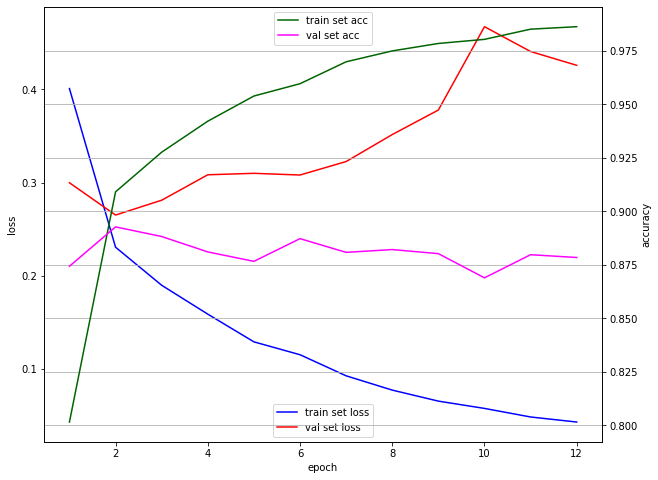

In [15]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='train set loss')
ax0.plot(x_len, y_vloss, c="red", label='val set loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='train set acc')
ax1.plot(x_len, y_vacc, c="magenta", label='val set acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.grid()
plt.show()